In [1]:
%matplotlib inline
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('bright')
plt.style.use('ggplot')
import statsmodels.formula.api as smf
from nipype.interfaces.afni.preprocess import TCorr1D
plt.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color': "white",
                     'ytick.color': "white"})

In [2]:
# the melodic output giving each ICA timeseries
ica_ts = pd.read_csv('./data/test_bold_MELODICmix.tsv', sep='\t', header=None)
ica_ts.dropna(axis='columns', how='all', inplace=True)
ica_ts = ica_ts.add_prefix('comp_')
ica_ts.head()


,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,...,comp_63,comp_64,comp_65,comp_66,comp_67,comp_68,comp_69,comp_70,comp_71,comp_72
0,-0.758030,-1.186418,0.790879,-2.197487,1.143364,0.027185,-0.401727,-0.266738,-0.899754,2.957095,...,0.202970,-0.757285,0.580424,-2.170545,1.135138,1.185032,0.161144,-1.449952,-0.340129,3.207329
1,0.855021,1.225001,2.436515,-0.110996,-1.360332,-0.645831,0.705279,-0.529328,-0.961012,3.887399,...,-1.151278,-1.355444,0.157133,-1.456655,-1.614684,-0.420475,2.215335,-0.568601,-1.310884,-0.647429
2,-1.378687,-1.099753,0.282676,-1.600301,-0.390527,-0.477530,-0.573430,-0.526413,-1.896047,2.362592,...,-0.269990,0.657094,0.669171,-0.859728,0.482538,1.614340,-0.225722,-1.383938,1.844453,1.692464
3,3.310646,1.226795,2.549461,0.782276,-0.979568,0.248360,0.926625,-0.615597,-1.456201,3.235565,...,-0.873392,0.517578,0.564591,-1.450724,-1.293111,-1.069044,1.296962,-1.100991,1.450045,-0.018287
4,-1.753966,-1.724009,-0.885913,-2.228024,0.471514,-0.653573,-1.937831,-0.583467,-1.993739,1.610389,...,-0.965310,-0.250692,1.413558,-0.252963,1.918096,1.726810,-0.392606,-1.935342,2.626670,1.386460


In [3]:
# load the noise indices
ica_noise_idx = np.loadtxt('./data/test_bold_AROMAnoiseICs.csv', delimiter=',', dtype='int')
ica_noise_idx -= 1
ica_noise_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35,
       36, 37, 38, 39, 41, 42, 43, 44, 48, 49, 50, 52, 53, 56, 58, 59, 60,
       61, 62, 64, 65, 66, 67, 69, 70, 72])

In [4]:
signal_noise_idx = np.full(len(ica_ts.columns), 'signal')
signal_noise_idx[ica_noise_idx] = 'noise'
signal_noise_idx


array(['noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'signal', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'signal', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'noise', 'noise', 'signal', 'noise',
       'noise', 'noise', 'noise', 'signal', 'signal', 'signal', 'noise',
       'noise', 'noise', 'signal', 'noise', 'noise', 'signal', 'signal',
       'noise', 'signal', 'noise', 'noise', 'noise', 'noise', 'noise',
       'signal', 'noise', 'noise', 'noise', 'noise', 'signal', 'noise',
       'noise', 'signal', 'noise'], dtype='<U6')

In [5]:
color_idx = np.array([st.replace('noise', 'red').replace('signal', 'green') for st in signal_noise_idx])
color_idx

array(['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'green',
       'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'green', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'green', 'red', 'red', 'red', 'red',
       'green', 'green', 'green', 'red', 'red', 'red', 'green', 'red',
       'red', 'green', 'green', 'red', 'green', 'red', 'red', 'red',
       'red', 'red', 'green', 'red', 'red', 'red', 'red', 'green', 'red',
       'red', 'green', 'red'], dtype='<U5')

In [6]:
# the confounds tsv
confounds = pd.read_csv('./data/test_bold_confounds.tsv', sep='\t')
confounds['FramewiseDisplacement'][0] = confounds['FramewiseDisplacement'][1:].mean()
confounds.head()

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,AROMAAggrComp61,AROMAAggrComp62,AROMAAggrComp63,AROMAAggrComp65,AROMAAggrComp66,AROMAAggrComp67,AROMAAggrComp68,AROMAAggrComp70,AROMAAggrComp71,AROMAAggrComp73
0,4.826616,0.244417,2.084664,NaN,NaN,NaN,0.390440,0.056869,-0.006587,-0.105907,...,1.977688,-0.869653,-1.181006,-0.757285,0.580424,-2.170545,1.135138,0.161144,-1.449952,3.207329
1,-1.675956,0.401133,0.607724,1.245240,10.564131,1.052146,0.619482,-0.001804,0.011459,-0.078431,...,0.173481,-0.326303,-0.542473,-1.355444,0.157133,-1.456655,-1.614684,2.215335,-0.568601,-0.647429
2,1.086976,0.593310,1.711596,1.329685,11.280532,1.202394,0.376306,0.035729,-0.029645,0.066901,...,1.663285,-1.108394,-2.723212,0.657094,0.669171,-0.859728,0.482538,-0.225722,-1.383938,1.692464
3,-0.268196,0.270533,0.871375,1.173665,9.956918,1.019827,0.207354,-0.000183,0.035827,-0.071468,...,-0.443019,1.377220,-0.745638,0.517578,0.564591,-1.450724,-1.293111,1.296962,-1.100991,-0.018287
4,1.103928,0.219790,1.583645,1.300516,11.033072,1.109406,0.497735,0.077244,-0.001720,-0.012880,...,1.480062,-2.249758,-1.405533,-0.250692,1.413558,-0.252963,1.918096,-0.392606,-1.935342,1.386460


In [7]:
correlations = np.corrcoef(ica_ts, rowvar=False)

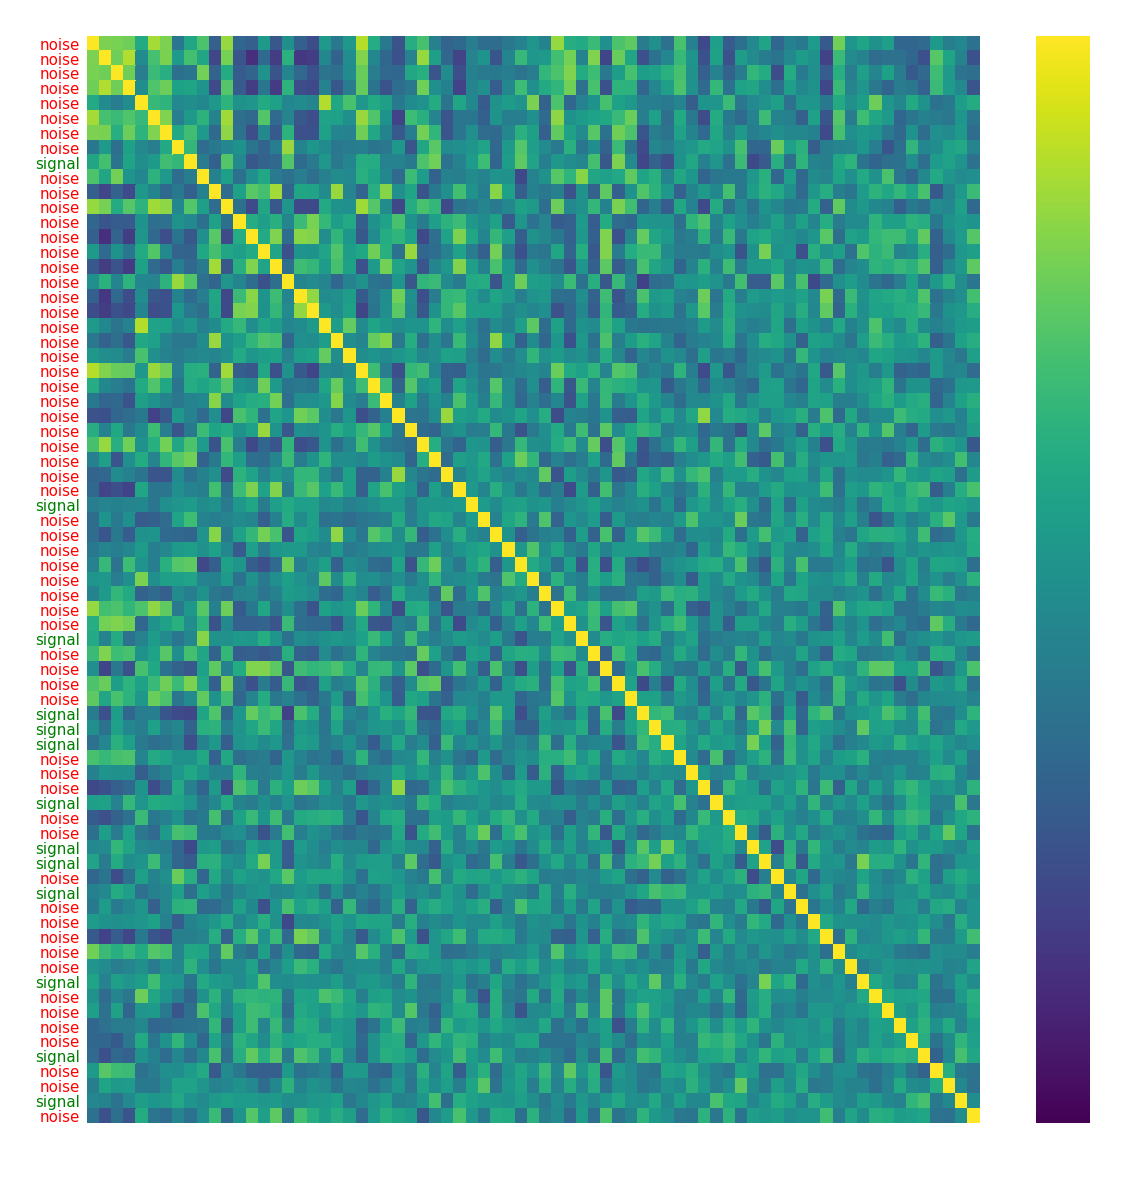

In [8]:
# make the figure bigger overall
plt.rcParams["figure.figsize"] = (20,20)
fig = sns.heatmap(correlations, 
                  yticklabels=signal_noise_idx, #label the yaxis with individual markers
                  vmin=-1, vmax=1, # set the colorbar to go from -1 to 1
                  cmap='viridis') # have the color gradient go from red to blue
for color,tick in zip(color_idx, fig.yaxis.get_major_ticks()):
    tick.label1.set_color(color) # set the individual colors
    tick.label1.set_fontsize('15') # increase the size
fig.set_ylabel('Classification (Signal or Noise)', fontdict={'fontsize': 25})
fig.set_xlabel('ICA Component Number', fontdict={'fontsize': 25})
fig.set_title('Correlation of ICA Components', fontdict={'fontsize': 30})
plt.savefig('./imgs/correlation_ica_components.png', transparent=True)

In [9]:
# get a voxel in the right insula
bold_img = nib.load('./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
bold_data = bold_img.get_data()
right_insula = bold_data[37,44,19]
right_insula_df = pd.DataFrame.from_dict({'right_insula': right_insula})

In [10]:
# Component 47 (e.g. indexed 46) looks like fronto-parietal network
# ica_ts[46]
aroma_confounds = confounds.filter(regex='AROMA.*')
aroma_confounds.insert(0, 'right_insula', right_insula)
aroma_confounds.head()

,right_insula,AROMAAggrComp01,AROMAAggrComp02,AROMAAggrComp03,AROMAAggrComp04,AROMAAggrComp05,AROMAAggrComp06,AROMAAggrComp07,AROMAAggrComp08,AROMAAggrComp10,...,AROMAAggrComp61,AROMAAggrComp62,AROMAAggrComp63,AROMAAggrComp65,AROMAAggrComp66,AROMAAggrComp67,AROMAAggrComp68,AROMAAggrComp70,AROMAAggrComp71,AROMAAggrComp73
0,1062.597202,-0.758030,-1.186418,0.790879,-2.197487,1.143364,0.027185,-0.401727,-0.266738,2.957095,...,1.977688,-0.869653,-1.181006,-0.757285,0.580424,-2.170545,1.135138,0.161144,-1.449952,3.207329
1,1046.651915,0.855021,1.225001,2.436515,-0.110996,-1.360332,-0.645831,0.705279,-0.529328,3.887399,...,0.173481,-0.326303,-0.542473,-1.355444,0.157133,-1.456655,-1.614684,2.215335,-0.568601,-0.647429
2,1069.717156,-1.378687,-1.099753,0.282676,-1.600301,-0.390527,-0.477530,-0.573430,-0.526413,2.362592,...,1.663285,-1.108394,-2.723212,0.657094,0.669171,-0.859728,0.482538,-0.225722,-1.383938,1.692464
3,1059.911231,3.310646,1.226795,2.549461,0.782276,-0.979568,0.248360,0.926625,-0.615597,3.235565,...,-0.443019,1.377220,-0.745638,0.517578,0.564591,-1.450724,-1.293111,1.296962,-1.100991,-0.018287
4,1059.868596,-1.753966,-1.724009,-0.885913,-2.228024,0.471514,-0.653573,-1.937831,-0.583467,1.610389,...,1.480062,-2.249758,-1.405533,-0.250692,1.413558,-0.252963,1.918096,-0.392606,-1.935342,1.386460


Text(0.5,0,'Time (Seconds)')

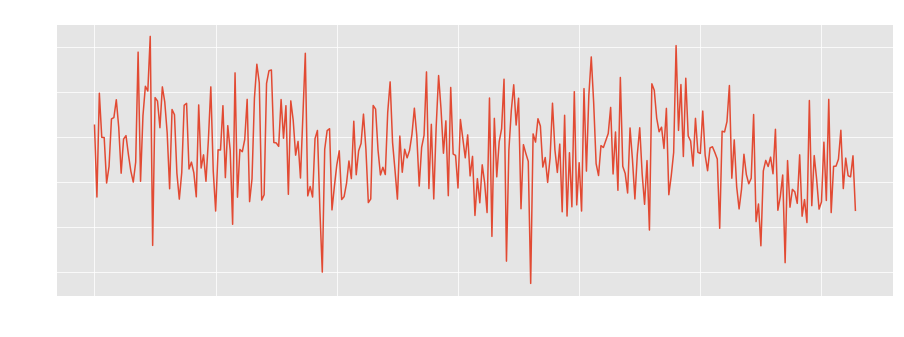

In [11]:
# get the frequency spectra of the signal component
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(aroma_confounds['right_insula'])
plt.title('right insula voxel')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Seconds)')

In [12]:
# statsmodels (aggressive denoising)
column_names = aroma_confounds.columns.tolist()
column_names.remove('right_insula')
all_columns = "+".join(column_names)

model_agg = smf.ols('right_insula ~ ' + all_columns, data=aroma_confounds)

In [13]:
fit_agg = model_agg.fit()

Text(0.5,0,'Time (Seconds)')

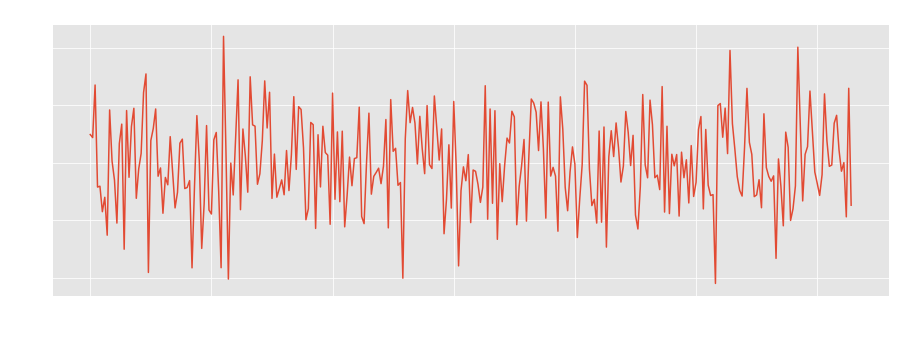

In [14]:
plt.plot(fit_agg.resid)
plt.title('fronto-parietal component (cleaned)')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Seconds)')

In [15]:
fit_agg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           right_insula   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     20.93
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           6.78e-70
Time:                        00:07:18   Log-Likelihood:                -872.46
No. Observations:                 315   AIC:                             1867.
Df Residuals:                     254   BIC:                             2096.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1056.5928      0.242   4362.098      0.000    1056.116    1057.070
AROMAAggrComp01     0.2291      0.794      0.288      0.773      -1.335       1.793
AROMAAggrComp02    -0.1159      1.043     -0.111      0.912      -2.170       1.938
AROMAAggrComp03    -0.5658      0.751     -0.753      0.452      -2.045       0.913
AROMAAggrComp04     0.8155      0.793      1.028      0.305      -0.747       2.378
AROMAAggrComp05    -2.3595      0.732     -3.222      0.001      -3.802      -0.917
AROMAAggrComp06     1.7459      0.670      2.607      0.010       0.427       3.065
AROMAAggrComp07     2.2821      0.627      3.642      0.000       1.048       3.516
AROMAAggrComp08     0.1947      0.588      0.331      0.741      -0.964       1.353
AROMAAggrComp10     0.5734      0.598      0.959      0.338      -0.604       1.751
AROMAAggrComp11    -0.0687      0.647     -0.106      0.916      -1.343       1.206
AROMAAggrComp12    -0.9683      0.720     -1.345      0.180      -2.386       0.449
AROMAAggrComp13     1.6330      0.553      2.951      0.003       0.543       2.723
AROMAAggrComp14    -1.7513      0.641     -2.733      0.007      -3.013      -0.489
AROMAAggrComp15     0.1853      0.673      0.275      0.783      -1.141       1.512
AROMAAggrComp16     1.2742      0.622      2.049      0.041       0.050       2.499
AROMAAggrComp17     0.5622      0.575      0.977      0.330      -0.571       1.696
AROMAAggrComp18    -1.0074      0.574     -1.756      0.080      -2.137       0.122
AROMAAggrComp19     6.7333      0.632     10.652      0.000       5.488       7.978
AROMAAggrComp20     1.3174      0.657      2.005      0.046       0.024       2.611
AROMAAggrComp21     1.5261      0.546      2.794      0.006       0.450       2.602
AROMAAggrComp22    -0.7698      0.489     -1.575      0.116      -1.732       0.193
AROMAAggrComp23    -0.8952      0.605     -1.480      0.140      -2.086       0.296
AROMAAggrComp24     1.8754      0.601      3.123      0.002       0.693       3.058
AROMAAggrComp25    -0.8081      0.481     -1.679      0.094      -1.756       0.140
AROMAAggrComp26     0.3265      0.569      0.574      0.566      -0.794       1.447
AROMAAggrComp27     0.3626      0.557      0.651      0.516      -0.735       1.460
AROMAAggrComp28    -1.8765      0.524     -3.582      0.000      -2.908      -0.845
AROMAAggrComp29    -0.4240      0.588     -0.722      0.471      -1.581       0.733
AROMAAggrComp30     1.0655      0.539      1.978      0.049       0.005       2.126
AROMAAggrComp31     0.4824      0.477      1.011      0.313      -0.457       1.422
AROMAAggrComp33    -0.0422      0.572     -0.074      0.941      -1.169       1.085
AROMAAggrComp34    -0.9046      0.543     -1.667      0.097      -1.973       0.164
AROMAAggrComp35    -0.0489      0.485     -0.101      0.920

In [16]:
# non-aggressive
all_comps = '+'.join([str(x) for x in ica_ts.columns.tolist()])
model_noise = smf.ols('right_insula ~ ' + all_comps, data=pd.concat([ica_ts, right_insula_df], axis='columns'))
fit_noise = model_noise.fit()
noise_series = np.dot(ica_ts.iloc[:,ica_noise_idx], fit_noise.params[ica_noise_idx])
right_insula_nonaggr = right_insula_df['right_insula'] - noise_series

In [17]:
# write three text files for analysis
fit_agg.resid.to_csv('./data/right_insula-aggr.txt', index=False)
right_insula_df.to_csv('./data/right_insula-orig.txt', index=False, header=False)
right_insula_nonaggr.to_csv('./data/right_insula-nonaggr.txt', index=False)

In [18]:

afni_corr_objs = {}
for signal in ['orig', 'aggr', 'nonaggr']:
    afni_corr = TCorr1D(xset='./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
                        y_1d='./data/right_insula-{sig}.txt'.format(sig=signal),
                        args='-mask ./data/test_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz',
                        out_file='./data/right_insula-{sig}_corr.nii.gz'.format(sig=signal))
    res = afni_corr.run()
    afni_corr_objs[signal] = res.outputs.out_file


180925-00:07:19,236 nipype.interface INFO:
	 stderr 2018-09-25T00:07:19.235852:++ 3dTcorr1D: AFNI version=Debian-16.2.07~dfsg.1-5~nd16.04+1 (Jun 12 2017) [64-bit]
180925-00:07:19,264 nipype.interface INFO:
	 stderr 2018-09-25T00:07:19.264640:++ Number of voxels in mask = 41797
180925-00:07:19,265 nipype.interface INFO:
	 stderr 2018-09-25T00:07:19.264640: + reading dataset file ./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
180925-00:07:19,266 nipype.interface INFO:
	 stderr 2018-09-25T00:07:19.266164:** AFNI converts NIFTI_datatype=4 (INT16) in file ./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz to FLOAT32
180925-00:07:19,270 nipype.interface INFO:
	 stderr 2018-09-25T00:07:19.266164:     Warnings of this type will be muted for this session.
180925-00:07:19,271 nipype.interface INFO:
	 stderr 2018-09-25T00:07:19.266164:     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
180925-00:07:19,271 nipype.interface INFO:
	 stderr 2018-09-25T00:07:19.2661

orig
aggr
nonaggr


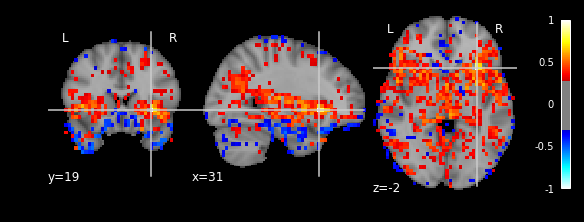

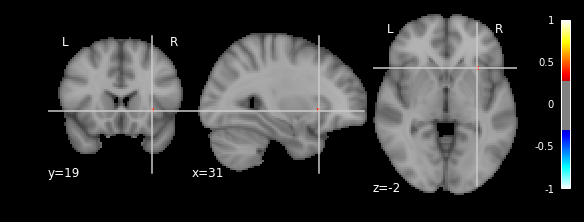

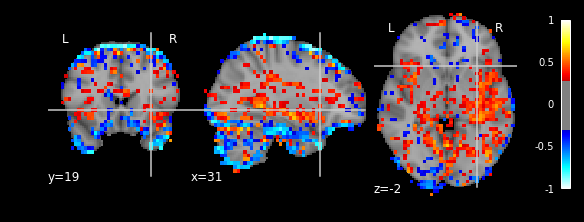

In [19]:
from nilearn.plotting import plot_stat_map
for signal, stat in afni_corr_objs.items():
    print(signal)
    plot_stat_map(stat, threshold=0.3, cut_coords=[31,19,-2], vmax=1.0, black_bg=True)
    plt.savefig('./imgs/{sig}_brain.png'.format(sig=signal), transparent=True)


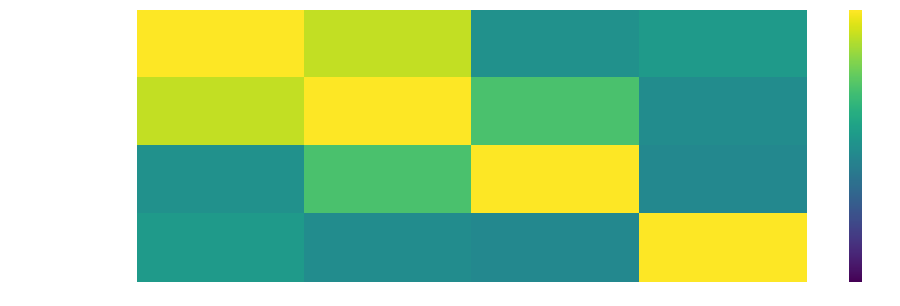

In [20]:
motion_params = ['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']
names = ['aggressive', 'original', 'nonaggressive']

sns.heatmap(np.corrcoef(np.array([fit_agg.resid, right_insula_df['right_insula'], right_insula_nonaggr]), confounds['FramewiseDisplacement'].T), 
            yticklabels=names + ['FramewiseDisplacement'], # label the yaxis with individual markers
            xticklabels=names + ['FramewiseDisplacement'],
            vmin=-0.5, vmax=0.5, # set the colorbar to go from -1 to 1
            center=0,
            cmap='viridis')

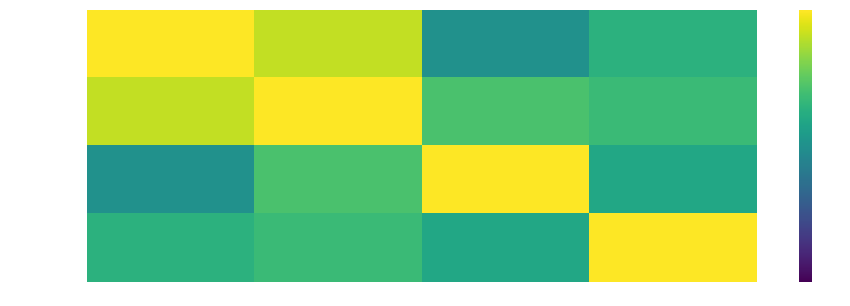

In [21]:
sns.heatmap(np.corrcoef(np.array([fit_agg.resid, right_insula_df['right_insula'], right_insula_nonaggr]), confounds['GlobalSignal'].T), 
            yticklabels=names + ['GlobalSignal'], # label the yaxis with individual markers
            xticklabels=names + ['GlobalSignal'],
            vmin=-0.5, vmax=0.5, # set the colorbar to go from -1 to 1
            center=0,
            cmap="viridis")

# Modular Preprocessing

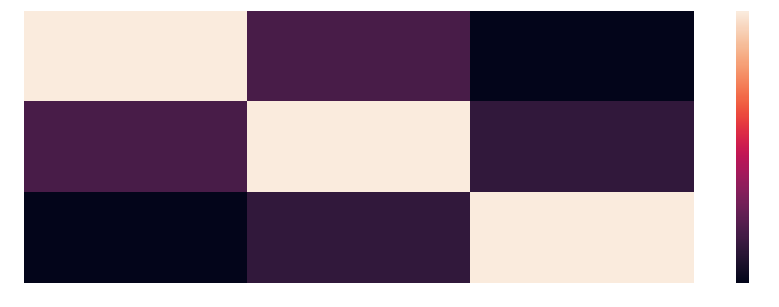

In [22]:
sns.heatmap(np.corrcoef(pd.concat([right_insula_df, confounds.GlobalSignal, confounds.FramewiseDisplacement], axis='columns'), rowvar=False))

In [23]:
pd.concat([right_insula_df, confounds.GlobalSignal, confounds.FramewiseDisplacement], axis='columns')

,right_insula,GlobalSignal,FramewiseDisplacement
0,1062.597202,2.084664,0.390440
1,1046.651915,0.607724,0.619482
2,1069.717156,1.711596,0.376306
3,1059.911231,0.871375,0.207354
4,1059.868596,1.583645,0.497735
5,1049.764230,0.144364,0.384280
6,1053.430793,-0.759333,0.781297
7,1064.004139,2.370601,0.733416
8,1064.302580,0.521469,0.451921
9,1068.267584,1.381078,0.297836


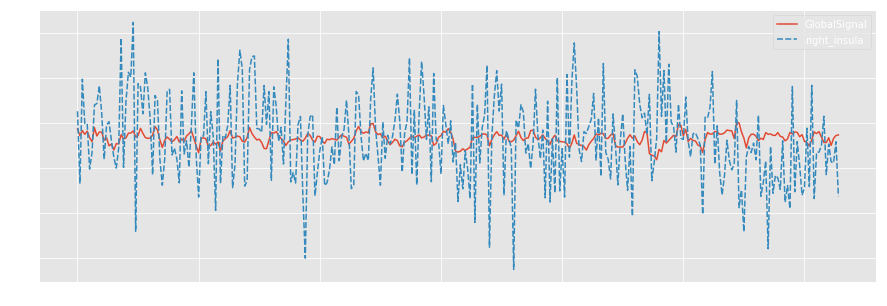

In [24]:
sns.lineplot(data=pd.concat([confounds.GlobalSignal + right_insula.mean(), right_insula_df], axis='columns'))

In [25]:
# bold_image = nib.load('./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
# mask_image = nib.load('./data/test_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')

In [26]:
# bold_data = bold_image.get_data()
# bold_data_2d = bold_data.reshape(np.prod(bold_data.shape[:-1]), bold_data.shape[-1])

In [27]:
# mask_data = mask_image.get_data()
# mask_data = mask_data.astype(bool)


In [28]:
# bold_data_masked = bold_data[mask_data]
# bold_data_masked.shape

In [29]:
from nilearn.connectome import ConnectivityMeasure
connectivity_measure = ConnectivityMeasure(kind='correlation')


## Dummy ICA example

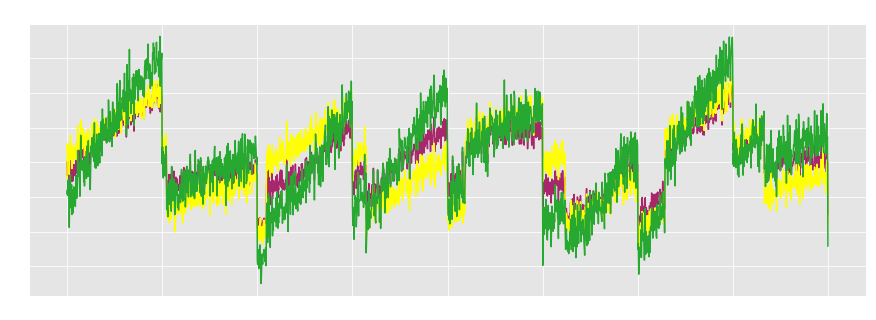

In [30]:
from scipy import signal

from sklearn.decomposition import FastICA, PCA
plt.rcParams["figure.figsize"] = (15,5)
# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

plt.figure()

models = [X, S, S_]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals']
colors = ['red', 'steelblue', 'orange']

plt.title(names[0])
for sig, color in zip(models[0].T, ['#a8276b', '#ffff00', '#27a830']):
    plt.plot(sig, color=color)
plt.savefig('./imgs/observations.png', transparent=True)

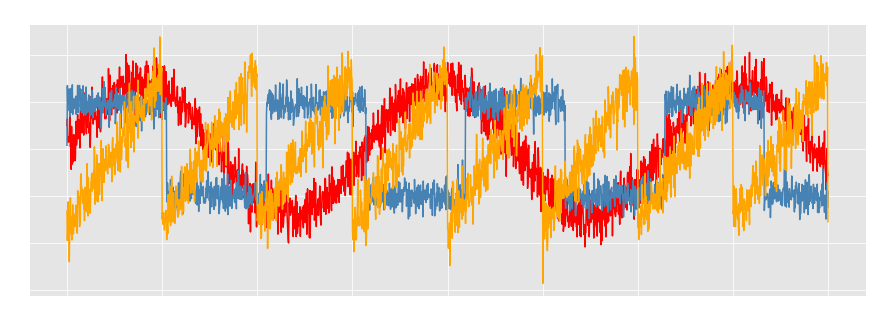

In [31]:
plt.figure()
plt.title(names[1])
for sig, color in zip(models[1].T, colors):
    plt.plot(sig, color=color)
plt.savefig('./imgs/true_sources.png', transparent=True)

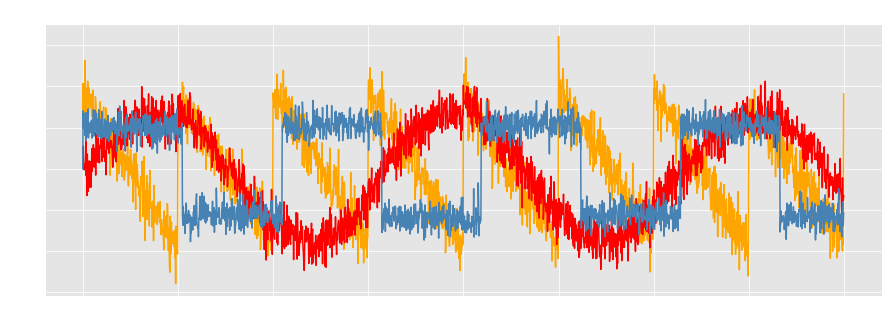

In [32]:
plt.figure()
plt.title(names[2])
for sig, color in zip(models[2].T, [colors[2], colors[0], colors[1]]):
    plt.plot(sig, color=color)
plt.savefig('./imgs/ica_recovered_signals.png', transparent=True)

## Venn Diagram

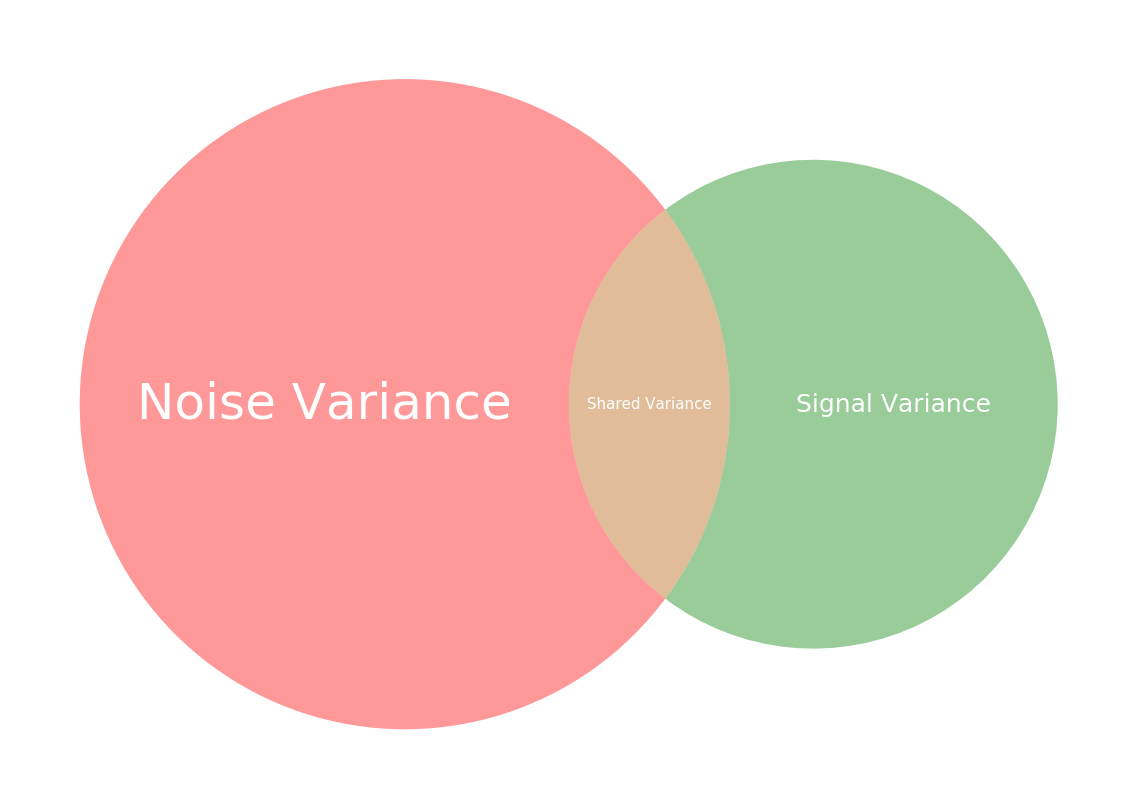

In [33]:
from matplotlib_venn import venn2
plt.rcParams["figure.figsize"] = (20, 20)
venn = venn2(subsets = {'10': 20, '01': 10, '11': 3}, set_labels=None)
venn.get_label_by_id('10').set_text('Noise Variance')
venn.get_label_by_id('10').set_size(50)
venn.get_label_by_id('01').set_text('Signal Variance')
venn.get_label_by_id('01').set_size(25)
venn.get_label_by_id('11').set_text('Shared Variance')
venn.get_label_by_id('11').set_size(15)
plt.savefig('./imgs/venn_diagram.png', transparent=True)
plt.show()

## Modular Preprocessing

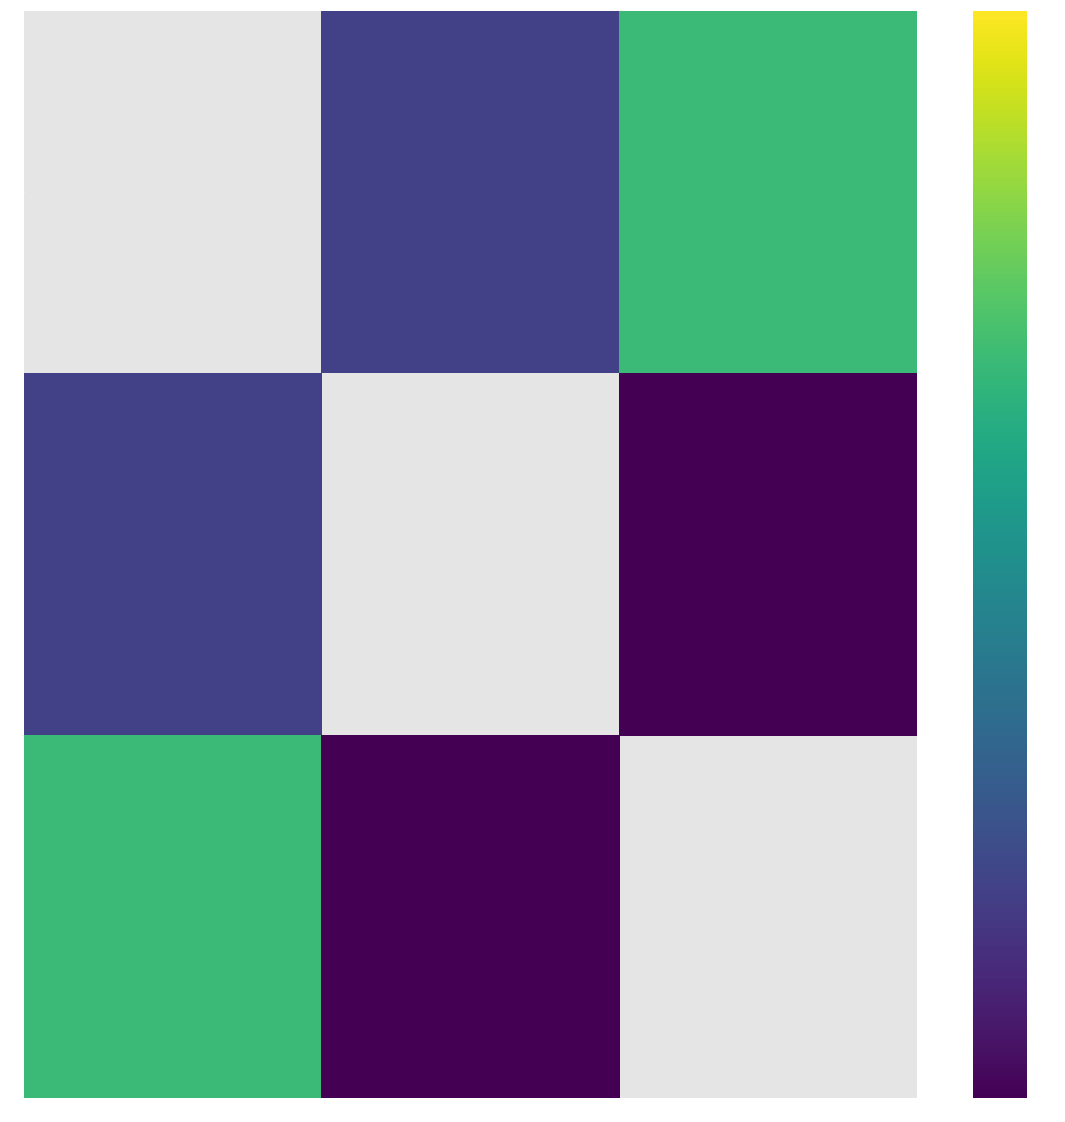

In [34]:
# right insula, motion (framewise displacement), and global signal
confound1 = confounds.aCompCor00
confound2 = confounds.GlobalSignal
modular_df = pd.concat([confound1, confound2, right_insula_df['right_insula']], axis='columns')
modular_df.columns = ['confound1', 'confound2', 'right_insula']
orig_corr = np.corrcoef([right_insula, confound1, confound2])
np.fill_diagonal(orig_corr, np.NaN)
sns.heatmap(orig_corr, vmin=-0.5, vmax=0.5, cmap='viridis')

In [35]:
# model confound1 then confound2
model_conf1 = smf.ols('right_insula ~ confound1', data=modular_df)
fit_conf1 = model_conf1.fit()
modular_df['right_insula_conf1'] = fit_conf1.resid
model_conf1_conf2 = smf.ols('right_insula_conf1 ~ confound2', data=modular_df)
fit_conf1_conf2 = model_conf1_conf2.fit()
modular_df['right_insula_conf1_conf2'] = fit_conf1_conf2.resid

# model confound2 then confound1
model_conf2 = smf.ols('right_insula ~ confound2', data=modular_df)
fit_conf2 = model_conf2.fit()
modular_df['right_insula_conf2'] = fit_conf2.resid
model_conf2_conf1 = smf.ols('right_insula_conf2 ~ confound1', data=modular_df)
fit_conf2_conf1 = model_conf2_conf1.fit()
modular_df['right_insula_conf2_conf1'] = fit_conf2_conf1.resid

# simultaneous
model_simult = smf.ols('right_insula ~ confound1 + confound2', data=modular_df)
fit_simult = model_simult.fit()
modular_df['right_insula_simult'] = fit_simult.resid

In [36]:
# original correlation
orig_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'right_insula']], rowvar=False)
# reintroduce correlations with confound1
conf1_conf2_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'right_insula_conf1_conf2']], rowvar=False)
# reintroduce correlations with confound2
conf2_conf1_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'right_insula_conf2_conf1']], rowvar=False)
# no correlations with confounds
simult_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'right_insula_simult']], rowvar=False)
corrs = [orig_corr, conf1_conf2_corr, conf2_conf1_corr, simult_corr]

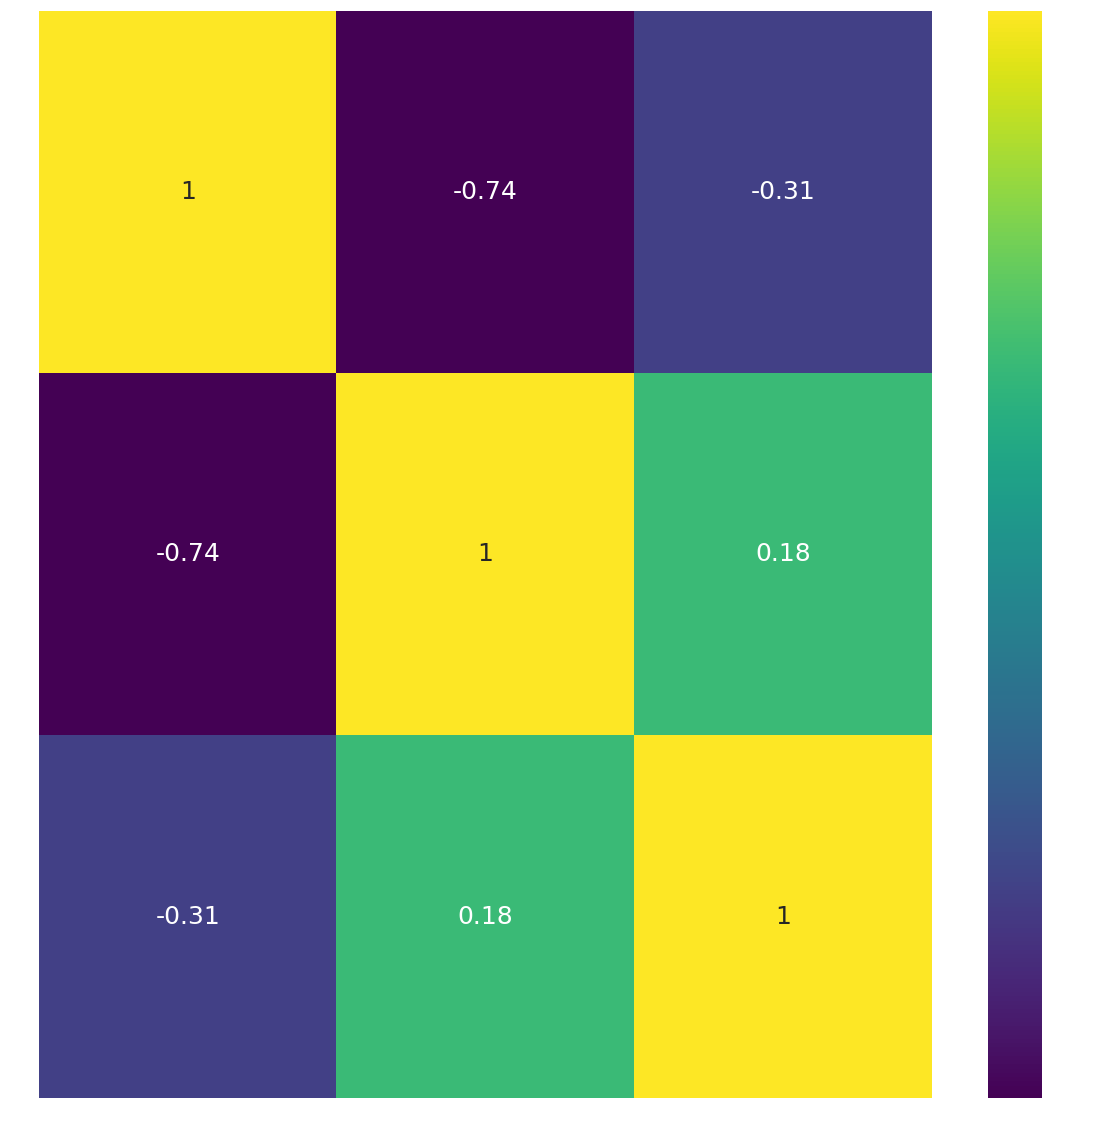

In [37]:
font = {'size': 25}

plt.rc('font', **font)

orig_corr_hm = sns.heatmap(corrs[0], vmin=-0.5, vmax=0.5, cmap='viridis', 
                           xticklabels=['confound1', 'confound2', 'right_insula'],
                           yticklabels=['confound1', 'confound2', 'right_insula'],
                           annot=True,
                           )
plt.savefig('./imgs/hm-corr_orig.png', transparent='True')

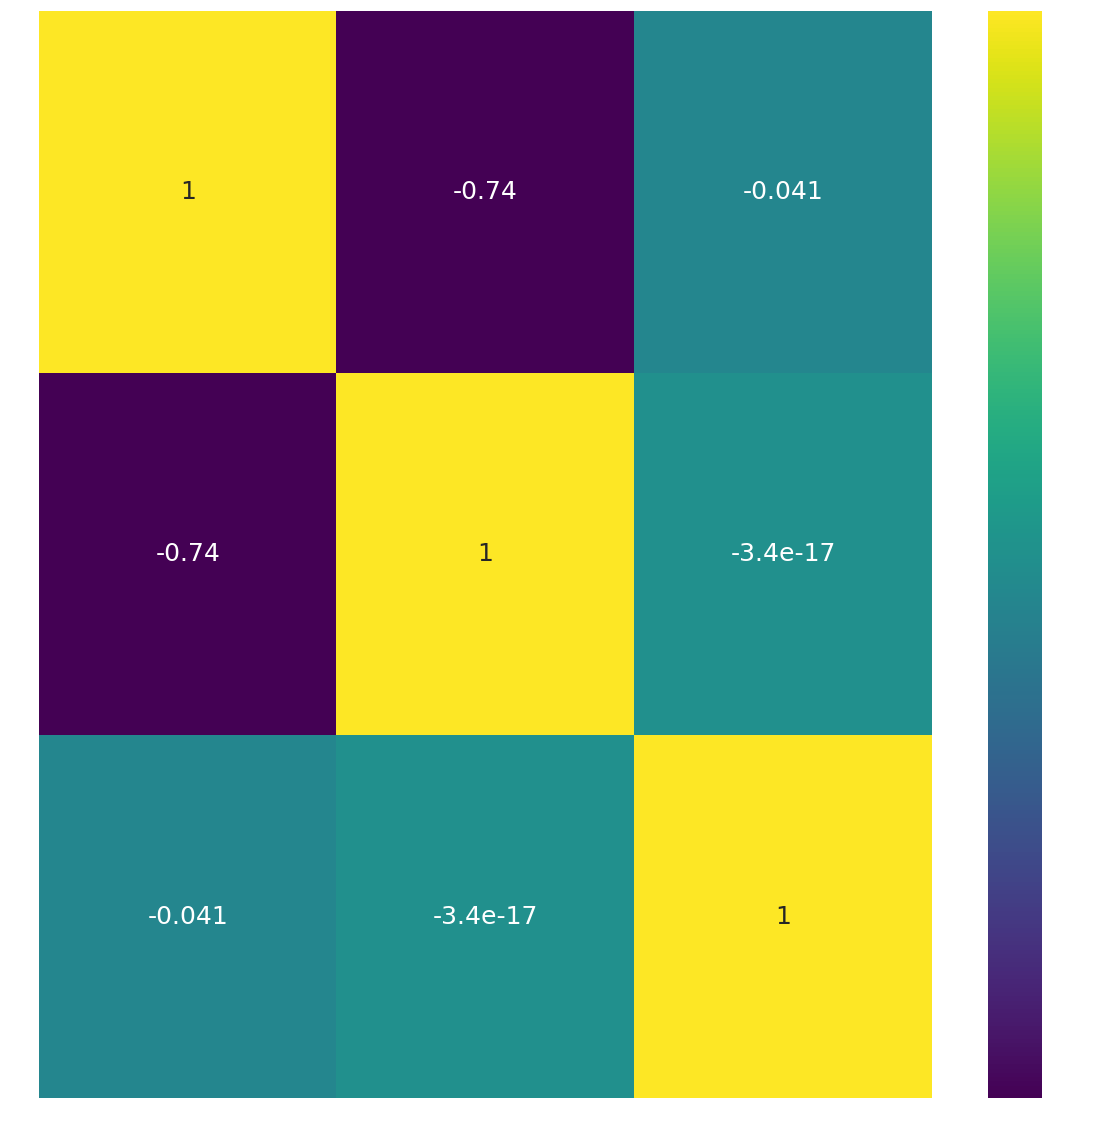

In [43]:
conf1_conf2_corr_hm = sns.heatmap(corrs[1], vmin=-0.5, vmax=0.5, cmap='viridis', 
                                  xticklabels=['confound1', 'confound2', 'right_insula'],
                                  yticklabels=['confound1', 'confound2', 'right_insula'],
                                  annot=True,
                                  )
plt.savefig('./imgs/hm-corr_conf1-conf2.png', transparent='True')

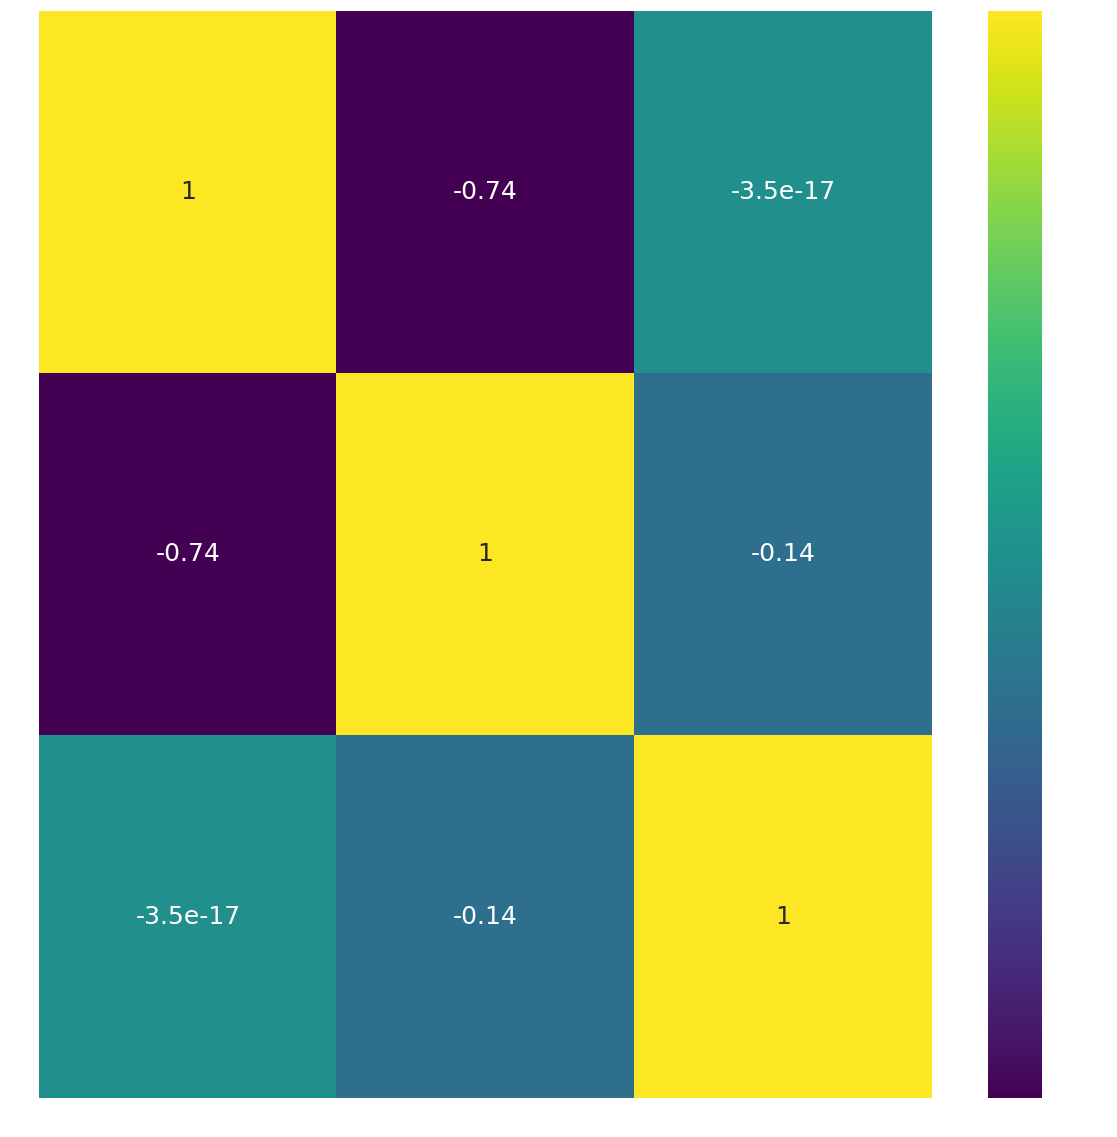

In [44]:
conf2_conf1_corr_hm = sns.heatmap(corrs[2], vmin=-0.5, vmax=0.5, cmap='viridis', 
                                  xticklabels=['confound1', 'confound2', 'right_insula'],
                                  yticklabels=['confound1', 'confound2', 'right_insula'],
                                  annot=True,
                                  )
plt.savefig('./imgs/hm-corr_conf2-conf1.png', transparent='True')

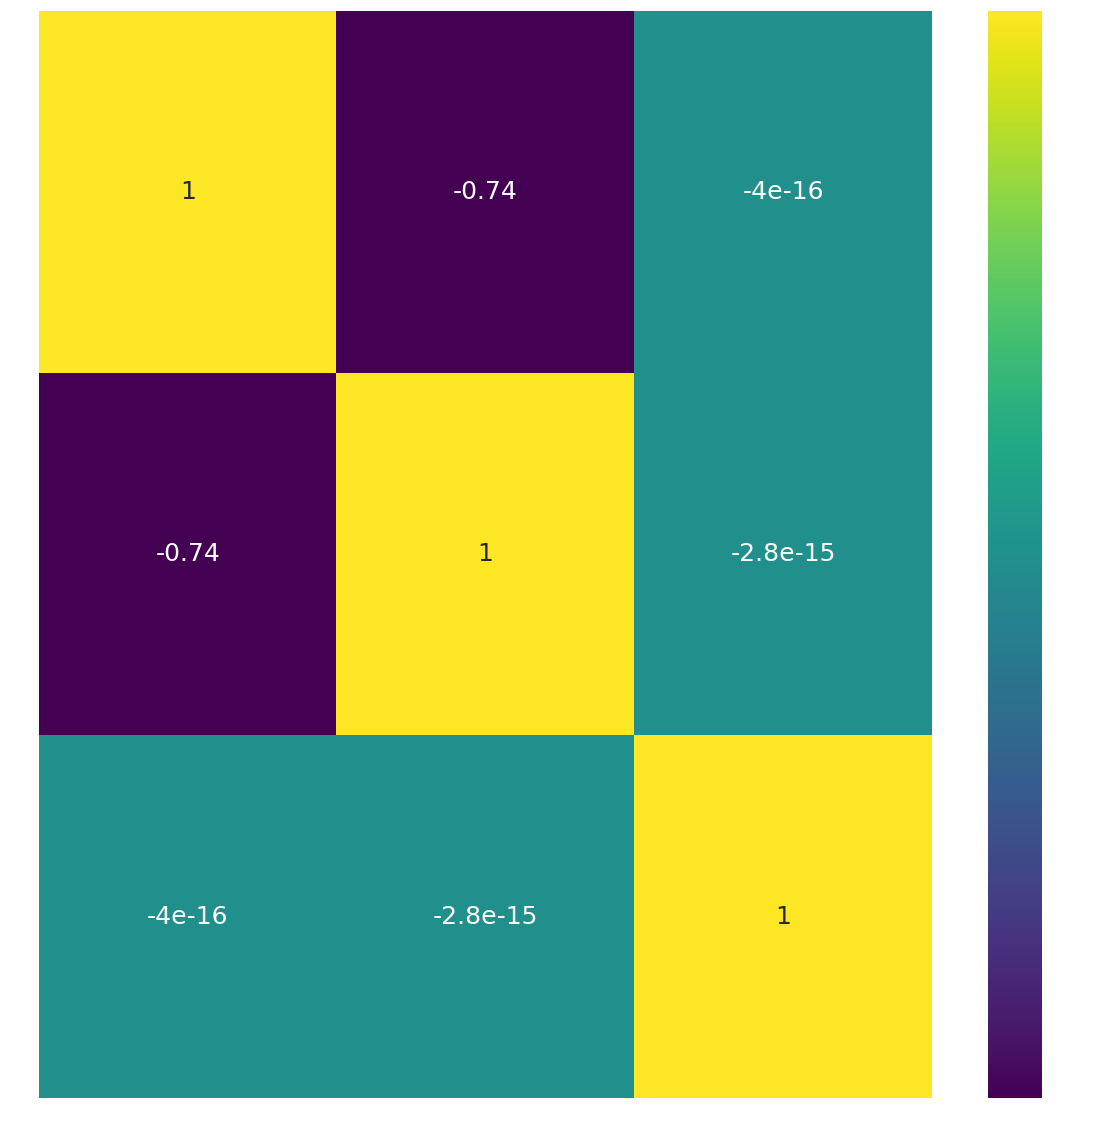

In [45]:
simult_corr_hm = sns.heatmap(corrs[3], vmin=-0.5, vmax=0.5, cmap='viridis', 
                             xticklabels=['confound1', 'confound2', 'right_insula'],
                             yticklabels=['confound1', 'confound2', 'right_insula'],
                             annot=True,
                             )
plt.savefig('./imgs/hm-corr_simult.png', transparent='True')